In [1]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()

print(repo_root)


expression_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
clinical_path = repo_root / os.getenv("CLINICAL_IMPUTED")

expression = pd.read_csv(expression_path, index_col=0)
clinical = pd.read_csv(clinical_path, index_col=0)

# Align samples
common_samples = expression.index.intersection(clinical.index)
X = expression.loc[common_samples]
clinical = clinical.loc[common_samples]

# Create binary target: 1 = Basal, 0 = Other
pam50_col = [col for col in clinical.columns if "pam50" in col.lower()][0]
y = (clinical[pam50_col] == "Basal").astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Other", "Basal"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


/Users/sarah/Code/bioinformatics-tool
              precision    recall  f1-score   support

       Other       0.99      0.98      0.99       587
       Basal       0.86      0.90      0.88        68

    accuracy                           0.97       655
   macro avg       0.92      0.94      0.93       655
weighted avg       0.97      0.97      0.97       655

Confusion matrix:
 [[577  10]
 [  7  61]]


In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# (Keep your data loading and preparation code here...)

# Set up the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

# Grid Search with 5-fold CV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Predict and evaluate
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Other", "Basal"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

       Other       0.99      1.00      0.99       587
       Basal       0.97      0.90      0.93        68

    accuracy                           0.99       655
   macro avg       0.98      0.95      0.96       655
weighted avg       0.99      0.99      0.99       655

Confusion matrix:
 [[585   2]
 [  7  61]]


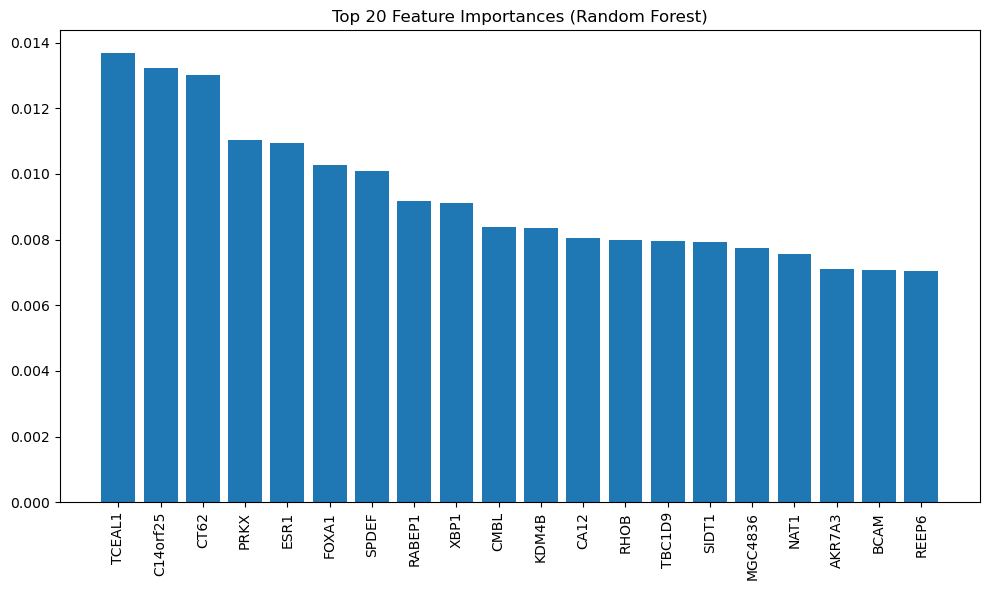

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from best estimator
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_

# If you have feature names (e.g., gene names)
feature_names = X_train.columns

# Sort and plot top N features (e.g., top 20)
indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


In [9]:
print(type(best_rf))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [10]:
explainer = shap.TreeExplainer(best_rf)
print(type(explainer))


<class 'shap.explainers._tree.TreeExplainer'>


In [11]:
shap_values = explainer.shap_values(X_test)
print(type(shap_values))
try:
    print(len(shap_values))
except TypeError:
    print("shap_values is not a list")
if isinstance(shap_values, list):
    print("shap_values[0] shape:", shap_values[0].shape)
else:
    print("shap_values shape:", shap_values.shape)


<class 'numpy.ndarray'>
655
shap_values shape: (655, 26150, 2)


shap_values type: <class 'numpy.ndarray'>
len(shap_values): 655
shap_values[0] shape: (26150, 2)
shap_values[1] shape: (26150, 2)


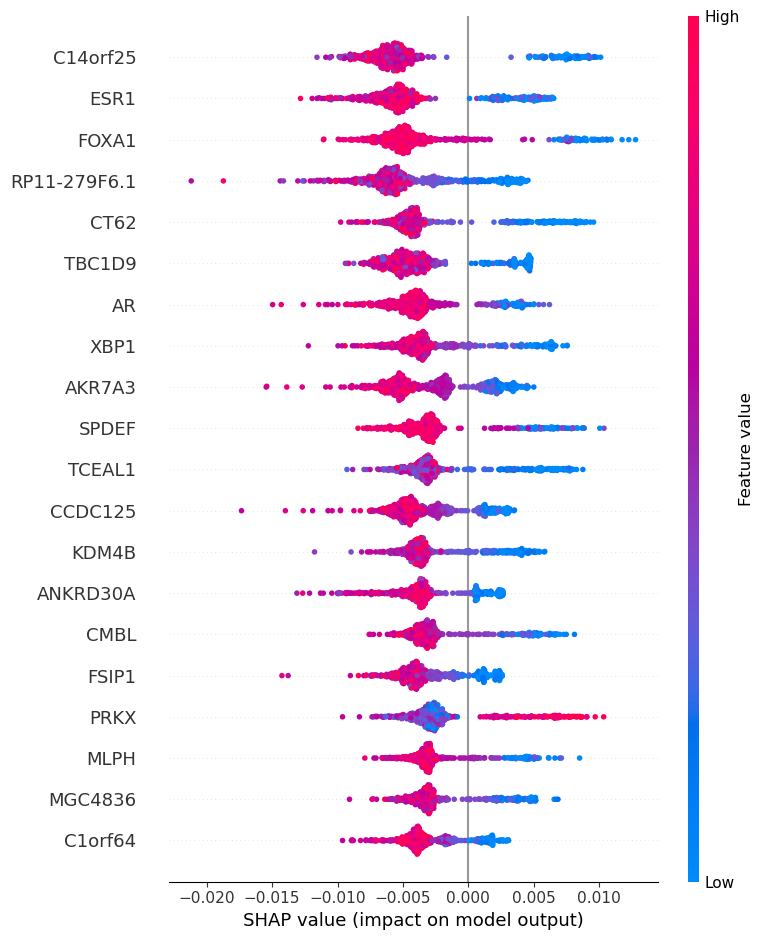

In [12]:
import shap

# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

import shap

# Use X_test as DataFrame, not transposed
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

print("shap_values type:", type(shap_values))
print("len(shap_values):", len(shap_values))
print("shap_values[0] shape:", shap_values[0].shape)
print("shap_values[1] shape:", shap_values[1].shape)


# Select SHAP values for class 1 ("Basal")
shap_values_basal = shap_values[:, :, 1]  # shape (655, 26150)
shap.summary_plot(shap_values_basal, X_test, feature_names=X_test.columns)

